# Buscalibre Data Analysis (For Topic Classification)

Analysis for the data scrapped from buscalibre website. **We are only considering the non-text columns** for the exploratio. Eventually, one can build multiples Statistical Learning Models using different sources to predict the same, and hopefully getting a better result after stacking into a whole set.

## Data Import

Import the Initial Libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy import stats
from scipy.stats import skew
sns.set_style("darkgrid")
sns.set_palette("Set2", 10)
palette = sns.color_palette("Set2", 10)
plt.style.use("seaborn")

Load the data (collected from the scrapping script) and define the Training and Test Sets. (**we are dropping the test target columns** to prevent information leakage).

In [2]:
path_folder = os.getcwd().replace("\\", "/") + "/"
path_parent = os.path.dirname(os.getcwd()).replace("\\", "/") + "/"
train = pd.read_csv(path_parent + "train.csv")
test = pd.read_csv(path_parent + "test.csv").drop(columns="topic")

Check both dataset's shape and five firsts rows.

In [3]:
print(f"Training Set shape: {train.shape}")
train.head()

Training Set shape: (2937, 12)


,isbn,name,author,publisher,year,language,pages,format,review,price,url,topic
0,9789563606843,Tu cabeza te engaña,Pamela nuñez,Planeta,2019.0,Español,104.0,Libro físico,¿Te ha pasado que los días previos a un evento...,8420,https://www.buscalibre.cl/libro-tu-cabeza-te-e...,espiritualidad-y-auto-ayuda
1,9789563608595,Nutrición emocional,Fran sabal,Planeta,2021.0,Español,270.0,Libro físico,¿Por qué el crecimiento personal es clave a la...,11820,https://www.buscalibre.cl/libro-nutricion-emoc...,espiritualidad-y-auto-ayuda
2,9789563609271,Historia de un milagro,Cristián arriagada,Planeta,2021.0,Español,140.0,Libro físico,"El año 2019, la periodista Javiera Suárez dejó...",10970,https://www.buscalibre.cl/libro-historia-de-un...,espiritualidad-y-auto-ayuda
3,9789501519914,La Inteligencia Emocional,Daniel goleman,Vergara,2004.0,Español,397.0,Libro físico,"En este fascinante y persuasivo libro, Daniel ...",11050,https://www.buscalibre.cl/libro-la-inteligenci...,espiritualidad-y-auto-ayuda
4,9789502805924,"Poder del Ahora, el",Tolle eckhart,Grijalbo,2000.0,Español,256.0,Libro físico,El poder del ahora es un libro único. Tiene la...,13600,https://www.buscalibre.cl/libro-poder-del-ahor...,espiritualidad-y-auto-ayuda


In [4]:
print(f"Test Set shape: {test.shape}")
test.head()

Test Set shape: (700, 11)


,isbn,name,author,publisher,year,language,pages,format,review,price,url
0,9789507301247,Youtuber School,Sebastian villalobos,Temas de hoy,2014.0,Español,160.0,Libro físico,Uno de los youtubers más importantes de Latino...,10970,https://www.buscalibre.cl/libro-youtuber-schoo...
1,9789871920990,El Opio y el Hachis,Gautier theophile,Interzona,2015.0,Castellano,72.0,Libro físico,Hasta el final de la cena yo me sentí perfecta...,6750,https://www.buscalibre.cl/libro-el-opio-y-el-h...
2,9789878000404,Harry Potter y la Piedra Filosofal [Harry Pott...,rowling j,Salamandra,2020.0,Español,288.0,Libro físico,Harry Potter se ha quedado huérfano y vive en ...,11900,https://www.buscalibre.cl/libro-harry-potter-y...
3,9789566056218,Abandonados,Carolina rojas,Ediciones b,2020.0,Español,NaN,Libro físico,"Durante varios años, Carolina Rojas ha investi...",10200,https://www.buscalibre.cl/libro-abandonados/97...
4,9789563254754,Lo que el Dinero si Puede Comprar (b),Carlos peña,Debolsillo,2020.0,Español,284.0,Libro físico,El crecimiento y la modernización asociados al...,6800,https://www.buscalibre.cl/libro-lo-que-el-dine...


## Duplicates

Duplicates have the potencial to bias future models development, so they should not be considered in the learning process. **We can only drop rows in the Training Set**, as Test Set will not be used to learn, but to predict.

The number of unique values in each column is.

In [5]:
print(f"Unique values in isbn column: {train.isbn.nunique()}")
print(f"Unique values in name column: {train.name.nunique()}")
print(f"Unique values in author column: {train.author.nunique()}")
print(f"Unique values in publisher column: {train.publisher.nunique()}")
print(f"Unique values in year column: {train.year.nunique()}")
print(f"Unique values in language column: {train.language.nunique()}")
print(f"Unique values in pages column: {train.pages.nunique()}")
print(f"Unique values in format column: {train.format.nunique()}")
print(f"Unique values in review column: {train.review.nunique()}")
print(f"Unique values in url column: {train.url.nunique()}")
print(f"Unique values in topic column: {train.topic.nunique()}")

Unique values in isbn column: 2721
Unique values in name column: 2698
Unique values in author column: 1853
Unique values in publisher column: 373
Unique values in year column: 34
Unique values in language column: 10
Unique values in pages column: 406
Unique values in format column: 3
Unique values in review column: 2539
Unique values in url column: 2721
Unique values in topic column: 13


There are 2721 unique isbns and 2721 unique urls, but we need to verify that duplicates isbn corresponds to duplicates url. The number of possible different values for urls for each isbn is


In [6]:
print(max(train.groupby("isbn")["url"].nunique().unique()))

1


So, there is only 1 unique url for each isbn, and we are dropping the rest.

In [7]:
train.drop_duplicates(subset="url", inplace=True)

The resulting Training Set's shape is

In [8]:
print(train.shape)

(2721, 12)


Similarly, the number of possible isbns for each book name is

In [9]:
name_group_num = train.groupby("name").nunique()
print(max(name_group_num["isbn"].unique()))

2


And the number of books that have a duplicate is

In [10]:
print(name_group_num[name_group_num["isbn"] == 2].shape[0])

23


23 pairs of books share the same name. We manually inspect every url for each pair.

In [11]:
duplicate_names = name_group_num[name_group_num["isbn"] == 2].index
#for i in range(23):
#    indeces = train[train.name == duplicate_names[i]].index
#    print(f"1st duplicate url with index {indeces[0]}: {train.url[indeces[0]]}")
#    print(f"2nd duplicate url with index {indeces[1]}: {train.url[indeces[1]]}")
#    print("\n")

**Based on the information provided by each page**, we are dropping some of them, and getting the resulting Training Set's shape as

In [12]:
train = train.drop(index=[1571, 403, 2290, 1100, 952, 1008, 722, 77, 55, 966])
print(train.shape)

(2711, 12)


In [13]:
train.reset_index(drop=True, inplace=True)

## Missing Data

To handle with missing data, we can consider both Training and Test Sets. First we concatenate both in one large dataframe of shape

In [14]:
df = pd.concat([train, test], ignore_index=True)
print(df.shape)

(3411, 12)


### Numeric Variables

The number of missing data for the numeric variables is

In [15]:
num_features = ["year", "pages", "price"]
print(df[num_features].isna().sum())

year     466
pages    364
price      0
dtype: int64


### Year

In the year column we have the following unique values

In [16]:
df["year"].unique()

array([ 2019.,  2021.,  2004.,  2000.,    nan,  2020.,  2014.,  2010.,
        2018.,  2015.,  2012.,  2013.,  1998.,  2007.,  2009.,  2016.,
        2008.,  2017.,  2011.,  2001.,  2002.,  2005.,  2006.,  2003.,
        1996.,  1993.,  1997.,  1970.,  1994.,  1972., 20021.,  1965.,
        1985.,  1962.,  1992.])

The statistical description of the column is

In [17]:
df.at[df["year"] == 20021, "year"] = 2021
year_col =  df[df["year"].isna() == False]["year"].astype("int")
year_col.describe()

count    2945.000000
mean     2016.138879
std         4.620966
min      1962.000000
25%      2014.000000
50%      2017.000000
75%      2019.000000
max      2021.000000
Name: year, dtype: float64

And the distribution of the column is

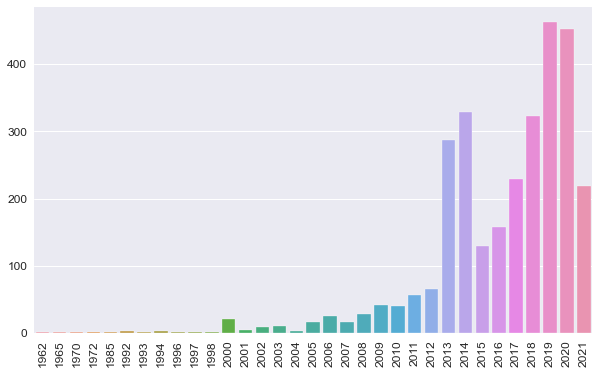

In [18]:
fig = plt.subplots(figsize=(10, 6))
sns.barplot(x=year_col.value_counts().index, y=year_col.value_counts().values)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Which is a nearly smooth exponential-like distribution. So, based on that, we can impute the missing data filling the cells with a forward criteria, maintaining the distribution.

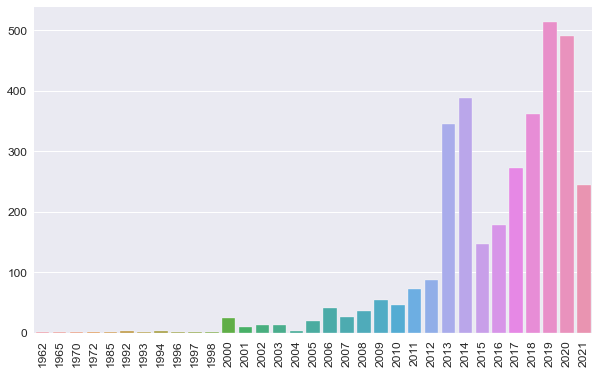

In [19]:
df["year"] = df["year"].fillna(method="ffill")
df["year"] = df["year"].astype("int")
fig = plt.subplots(figsize=(10, 6))
sns.barplot(x=df["year"].value_counts().index, y=df["year"].value_counts().values)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The relation between the Training Set's target column topic vs the year column is

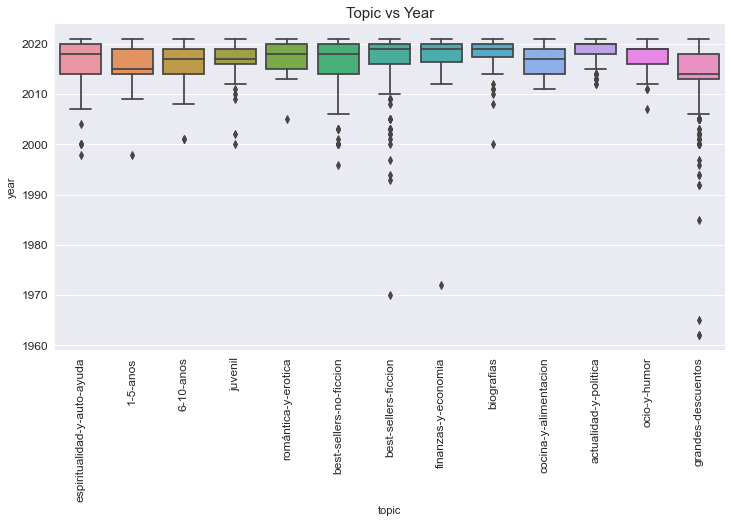

In [20]:
fig = plt.subplots(figsize=(12, 6))
sns.boxplot(y="year", x="topic", data=df.iloc[0:df.shape[0]-700])
plt.title("Topic vs Year", fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()

And for the last 20 and 10 years is, respectively,

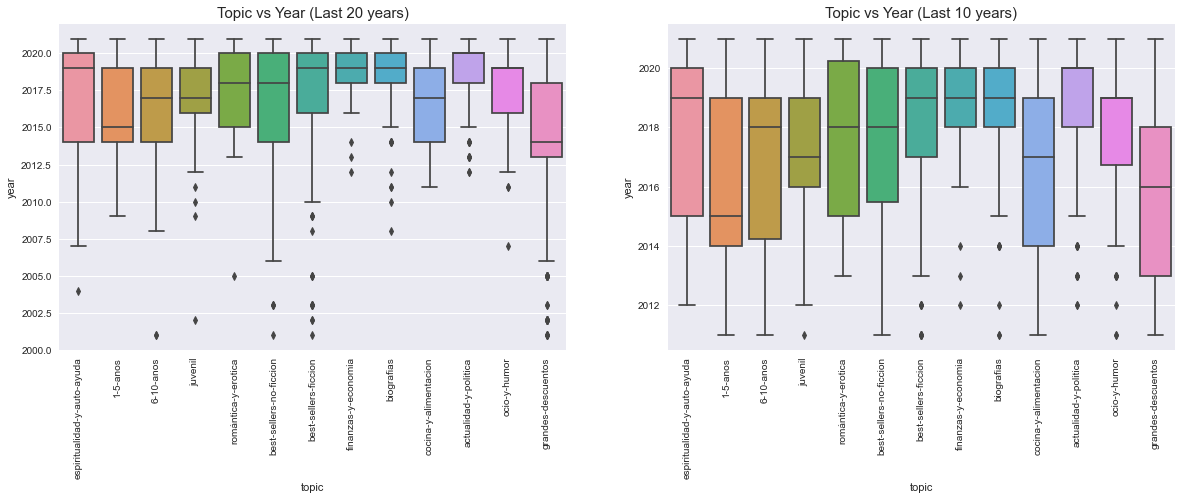

In [21]:
fig, axes = plt.subplots(ncols=2, figsize=(20, 6))
sns.boxplot(x="topic", y="year", data=df[df["year"] > 2000].iloc[0:df.shape[0]-700], ax=axes[0])
axes[0].set_title("Topic vs Year (Last 20 years)", fontsize=15)
axes[0].tick_params(axis="x", rotation=90)
sns.boxplot(x="topic", y="year", data=df[df["year"] > 2010].iloc[0:df.shape[0]-700], ax=axes[1])
axes[1].set_title("Topic vs Year (Last 10 years)", fontsize=15)
axes[1].tick_params(axis="x", rotation=90)
plt.show()

Finally we are min-max scaling the year column (for better calculations)

In [22]:
df["year_scaled"] = (df["year"] - min(df["year"])) / (max(df["year"]) - min(df["year"]))

### Pages

The description of the pages column, distribution and QQ-plot are

In [23]:
pages_col =  df[df["pages"].isna() == False]["pages"].astype("int")
pages_col.describe()

count    3047.000000
mean      271.000000
std       211.884756
min         1.000000
25%       144.000000
50%       227.000000
75%       352.000000
max      3872.000000
Name: pages, dtype: float64

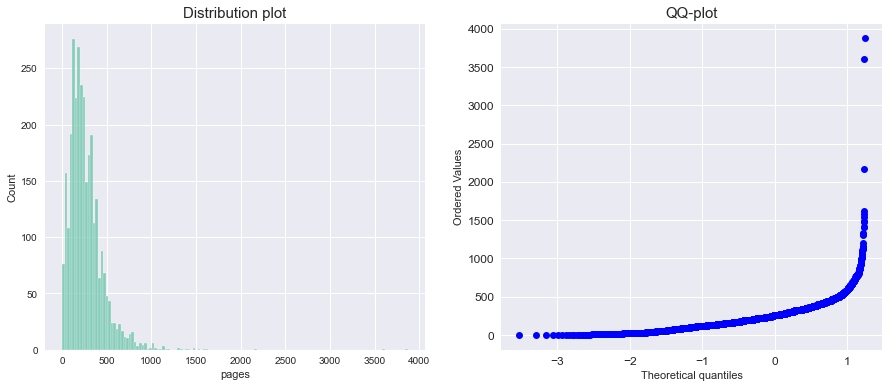

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.histplot(df["pages"], color=palette[0], ax=axes[0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats.probplot(df["pages"], plot=axes[1])
axes[0].set_title("Distribution plot", fontsize=15)
axes[1].set_title("QQ-plot", fontsize=15)
plt.show()

The pages columns has outliers and an right skew of 

In [25]:
print(skew(pages_col))

4.4434027334421105


We may first fill the missing data with a forward criteria

In [26]:
df["pages"] = df["pages"].fillna(method="ffill")
df["pages"] = df["pages"].astype("int")

To get a similar skew of

In [27]:
print(skew(df["pages"]))

4.353595912857687


Now **we can only remove the distribution outliers from the Training Set**. And the resulting Data shape will be 

In [28]:
df = df.drop(train[train["pages"] >= 900].index, axis=0)
df.shape

(3382, 13)

Also, a **Root Transformation to the entire column could mitigate some of the skewness**. The choice of the root can be improved to a better skewness, but for now, we are using a not so aggresive root of 2/5 to get the following graphs

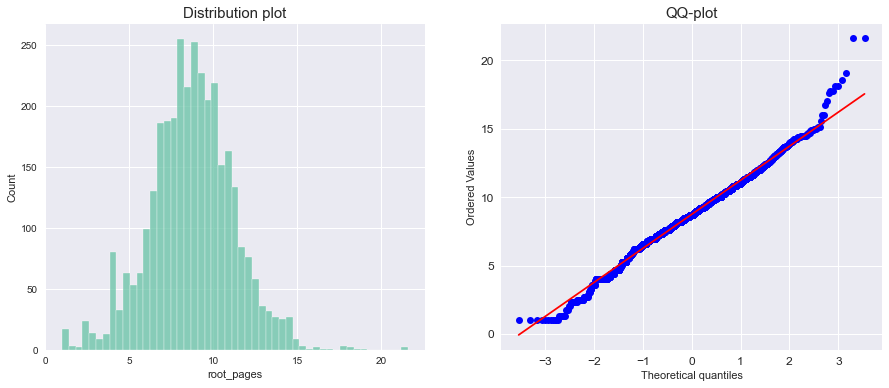

In [29]:
df["root_pages"] = df["pages"] ** (2/5)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.histplot(df["root_pages"], color=palette[0], ax=axes[0])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
stats.probplot(df["root_pages"], plot=axes[1])
axes[0].set_title("Distribution plot", fontsize=15)
axes[1].set_title("QQ-plot", fontsize=15)
plt.show()

And a final lower skew of 

In [30]:
skew(df["root_pages"])

0.025550952418601728

The relation between the Training Set target topic column vs the root_page column is presented as follows

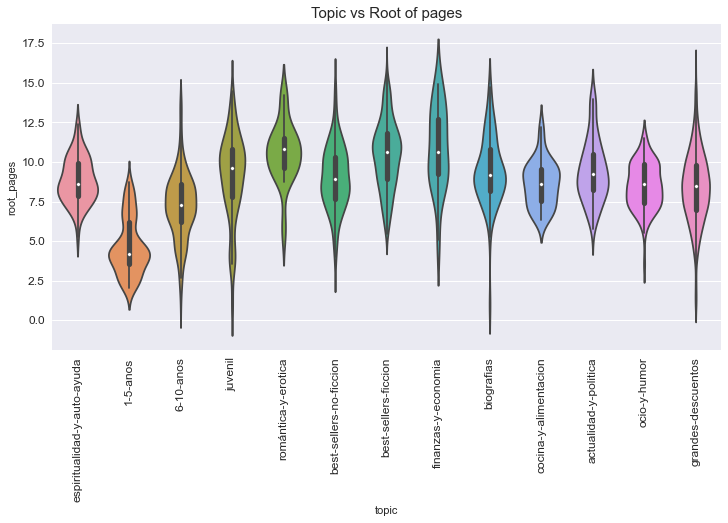

In [31]:
fig = plt.subplots(figsize=(12, 6))
sns.violinplot(x="topic", y="root_pages", data=df.iloc[0:df.shape[0]-700])
plt.title("Topic vs Root of pages", fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()

### Price

The graphs of the distribution of the whole price column are

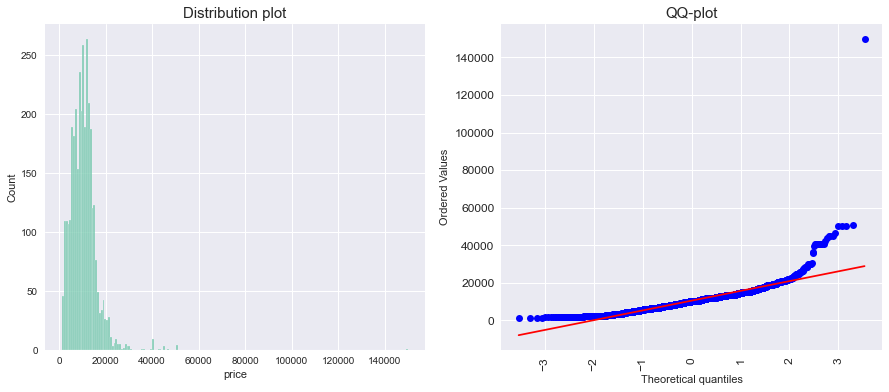

In [32]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.histplot(df["price"], color=palette[0], ax=axes[0])
stats.probplot(df["price"], plot=axes[1])
axes[0].set_title("Distribution plot", fontsize=15)
axes[1].set_title("QQ-plot", fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In the Training Set, the number of books with a price higher than 35000 is

In [33]:
sum(train["price"] >= 35_000)

23

And we are dropping them all

In [34]:
df = df.drop(index=[x for x in df[df["price"] >= 35_000].index if x < 2682])

The actual skewness of the entire column is

In [35]:
skew(df["price"])

1.0104195064348893

Similar to before, a **1/3-Root Transformation of the column will bring the distribution closer to a normal-like**

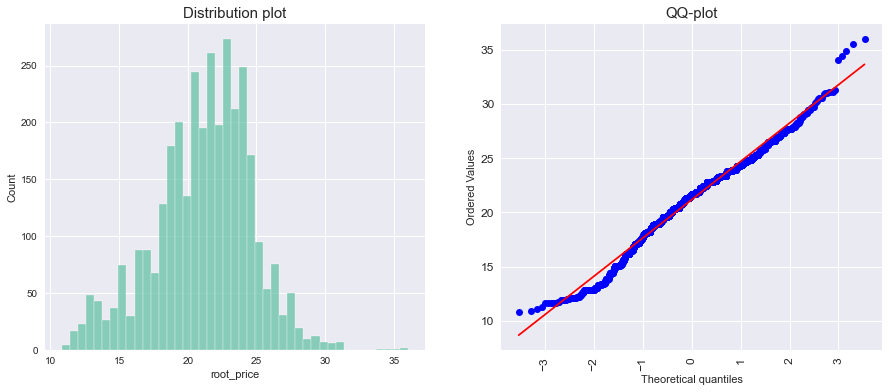

In [36]:
df["root_price"] = df["price"] ** (1/3)
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
sns.histplot(df["root_price"], color=palette[0], ax=axes[0])
stats.probplot(df["root_price"], plot=axes[1])
axes[0].set_title("Distribution plot", fontsize=15)
axes[1].set_title("QQ-plot", fontsize=15)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.show()

And reduce the skewness to

In [37]:
print(skew(df["root_price"]))

-0.2993170437448674


The relation between the Training Set topic column vs root_price column is presented in the following graph

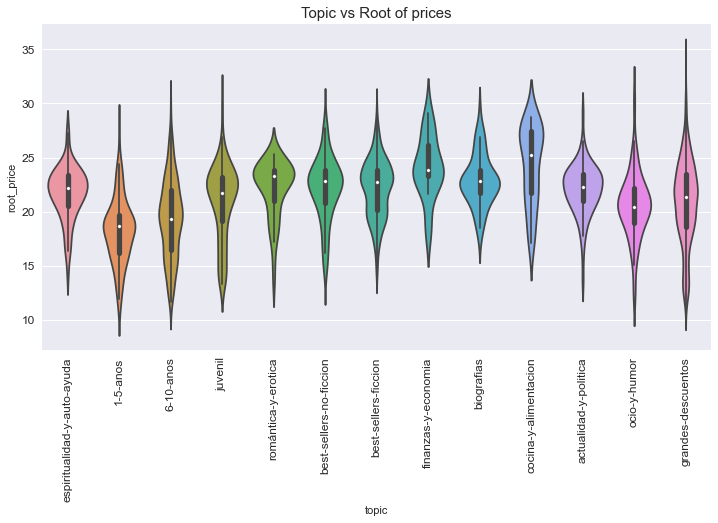

In [38]:
fig = plt.subplots(figsize=(12, 6))
sns.violinplot(x="topic", y="root_price", data=df.iloc[0:df.shape[0]-700])
plt.title("Topic vs Root of prices", fontsize=15)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.show()

In [39]:
df.reset_index(drop=True, inplace=True)

### Non Numeric Variables

The number of missing data in non numeric variables is

In [40]:
non_num_features = ["name", "author", "publisher", "language", "format"]
df[non_num_features].isna().sum()

name           0
author        53
publisher     23
language     183
format        10
dtype: int64

### Author

The following list represents de **possible numbers of differents isbns for each author**.

In [41]:
df.groupby("author")["isbn"].nunique().unique()

array([ 7,  1,  2,  3,  8,  4,  6,  5, 11, 13, 10, 23, 12, 15,  9, 32, 26,
       78], dtype=int64)

Being 78 the biggest one that corresponds to the label "varios autores" (multiple authors)

In [42]:
df.groupby("author")["isbn"].nunique().sort_values(ascending=False).head()

author
Varios autores    78
Tea stilton       32
Varios            26
Disney            23
Jorge baradit     15
Name: isbn, dtype: int64

The number missing authors of Training Set and to Test Set are, respectively

In [43]:
print(train["author"].isna().sum())
print(test["author"].isna().sum())

49
5


We will encode the name for a male and female columns. For that, we first load two datasets of spanish male and female names.

In [44]:
males = pd.read_csv(path_folder + "auxiliar_names_data/males.csv")["nombre"]
females = pd.read_csv(path_folder + "auxiliar_names_data/females.csv")["nombre"]

Check if there are missing values.

In [45]:
print(f"Missing data in males:\n {males.isna().sum()}\n")
print(f"Missing data in females:\n {females.isna().sum()}")

Missing data in males:
 0

Missing data in females:
 1


And remove them.

In [46]:
females = females.dropna(axis=0).reset_index(drop=True)
print(f"Shapes of each list:\n  males: {males.shape}, females: {females.shape}")

Shapes of each list:
  males: (25442,), females: (24493,)


Both datasets contains complete names, so we store just the first names in two lists (one for males and one for females)

In [47]:
males = [males[i].lower().split(" ")[0] for i in range(len(males))]
females = [females[i].lower().split(" ")[0] for i in range(len(females))]

Set **two new columns for the dataset: a column with 1 for male names (and 0 for the rest), and another columns with 1 for females names (and 0 for the rest)**.
Note that there are mislabels, that we will be treating manually.

In [48]:
df["author_male"] = 0
df["author_female"] = 0
for idx, item in df["author"].items():
    if df["author"].isna()[idx] == False:
        name = df["author"][idx].lower().split(" ")[0].replace("á", "a").replace(
            "é", "e").replace("í", "i").replace("ó", "o").replace("ú", "u")
        if name in females:
            df.at[idx, "author_female"] = 1
for idx, item in df["author"].items():
    if df["author"].isna()[idx] == False:
        name = df["author"][idx].lower().split(" ")[0].replace("á", "a").replace(
            "é", "e").replace("í", "i").replace("ó", "o").replace("ú", "u")
        if name in males:
            df.at[idx, "author_male"] = 1

Create two lists for authors that were labeled as both, and authors that were labeled as neither.

In [49]:
both = [
    i for i in range(df.shape[0])
    if df.at[i, "author_female"] == 1 and df.at[i, "author_male"] == 1
]
neither = [
    i for i in range(df.shape[0])
    if df.at[i, "author_female"] == 0 and df.at[i, "author_male"] == 0
]

We print all the both-neither-labeled authors with their data frame index, to inspect each name and reassign them manually.

In [50]:
#for i in both:
#    print(i, df.at[i, "author"])

In [51]:
males_checking = [
    23, 195, 253, 255, 266, 350, 421, 436, 465, 492, 493, 639, 645, 647, 669, 715, 778, 861, 891, 
    905, 916, 1177, 1206, 1229, 1234, 1241, 1318, 1339, 1389, 1433, 1434, 1740, 1773, 1775, 1777, 
    1782, 1795, 1796, 1825, 1829, 1888, 1910, 2051, 2072, 2081, 2177, 2220, 2311, 2351, 2361, 2456, 
    2498, 2531, 2544, 2559, 2570, 2578, 2589, 2688, 2727, 2792, 2804, 2805, 2811, 2854, 2937, 2955, 
    3050, 3063, 3112, 3117, 3124, 3144, 3163, 3241, 3275, 3296, 3360
]
no_gender_cheking = [593, 1235]
females_checking = [i for i in both if i not in males_checking and i not in no_gender_cheking]
for m in males_checking:
    df.at[m, "author_female"] = 0
for f in females_checking:
    df.at[f, "author_male"] = 0
for n in no_gender_cheking:
    df.at[n, "author_female"] = 0
    df.at[n, "author_male"] = 0

In [52]:
#for i in neither:
#    print(i, df.at[i, "author"])

In [53]:
males_checking2 = [
    4, 10, 32, 36, 48, 57, 71, 77, 85, 87, 93, 95, 101, 102, 103, 125, 157, 169, 173, 174, 175, 
    176, 180, 181, 183, 259, 263, 264, 283, 288, 291, 296, 305, 319, 353, 359, 367, 402, 410, 431, 
    438, 440, 462, 470, 476, 482, 496, 502, 525, 559, 603, 609, 618, 622, 633, 714, 755, 794, 831, 
    878, 903, 911, 933, 951, 997, 1019, 1020, 1027, 1033, 1041, 1046, 1063, 1070, 1071, 1079, 1108, 
    1133, 1143, 1154, 1182, 1236, 1242, 1244, 1247, 1256, 1258, 1321, 1322, 1325, 1332, 1345, 1351, 
    1353, 1359, 1361, 1375, 1435, 1448, 1495, 1497, 1498, 1500, 1504, 1580, 1613, 1618, 1646, 1650, 
    1651, 1660, 1662, 1705, 1717, 1725, 1736, 1739, 1760, 1769, 1810, 1822, 1855, 1862, 1868, 1881, 
    1907, 1928, 1977, 1979, 1981, 1994, 2012, 2014, 2034, 2049, 2050, 2057, 2071, 2078, 2099, 2108, 
    2112, 2113, 2120, 2121, 2125, 2135, 2143, 2144, 2145, 2146, 2147, 2155, 2170, 2194, 2216, 2222, 
    2227, 2242, 2262, 2265, 2290, 2308, 2314, 2316, 2329, 2332, 2335, 2349, 2354, 2357, 2362, 2388, 
    2394, 2407, 2408, 2414, 2416, 2444, 2464, 2476, 2513, 2521, 2554, 2557, 2563, 2567, 2649, 2658, 
    2665, 2681, 2714, 2750, 2754, 2755, 2756, 2757, 2762, 2766, 2779, 2810, 2837, 2842, 2844, 2851, 
    2885, 2889, 2904, 2915, 2929, 2938, 2946, 2985, 2997, 3004, 3010, 3020, 3035, 3070, 3109, 3115, 
    3116, 3141, 3148, 3162, 3173, 3175, 3188, 3192, 3197, 3218, 3266, 3268, 3274, 3289, 3293, 3305, 
    3327, 3328, 3338, 3340, 3354, 3362
]
females_checking2 = [
    34, 41, 152, 170, 182, 183, 187, 189, 260, 312, 342, 370, 380, 382, 395, 396, 397, 399, 404, 
    411, 422, 427, 437, 443, 444, 464, 477, 539, 551, 573, 580, 581, 583, 604, 627, 634, 651, 662, 
    684, 725, 776, 789, 791, 797, 809, 811, 830, 833, 852, 917, 937, 940, 949, 1128, 1132, 1136, 
    1173, 1264, 1278, 1288, 1290, 1296, 1304, 1340, 1367, 1372, 1379, 1394, 1450, 1458, 1462, 1468, 
    1589, 1654, 1656, 1803, 1832, 1893, 1905, 1911, 1923, 1961, 1964, 1975, 2087, 2154, 2162, 2195, 
    2199, 2203, 2226, 2264, 2276, 2317, 2348, 2403, 2417, 2507, 2510, 2546, 2666, 2684, 2704, 2740, 
    2769, 2785, 2786, 2790, 2852, 2865, 2869, 2947, 2988, 3037, 3041, 3058, 3098, 3202, 3207, 3236, 
    3312, 3319, 3326
]
for m in males_checking2:
    df.at[m, "author_female"] = 1
for f in females_checking2:
    df.at[f, "author_male"] = 1

The author_male and author_female columns statistics are

In [54]:
print("Statistics for males: \n", df[df["author_male"] == 1]["price"].describe())
print("\n")
print("Statistics for females: \n", df[df["author_female"] == 1]["price"].describe())

Statistics for males: 
 count     1723.000000
mean     10789.094602
std       4673.644828
min       1570.000000
25%       7500.000000
50%      10500.000000
75%      13500.000000
max      46740.000000
Name: price, dtype: float64


Statistics for females: 
 count     1135.000000
mean     10046.185022
std       4573.222304
min       1280.000000
25%       6800.000000
50%      10120.000000
75%      12750.000000
max      44940.000000
Name: price, dtype: float64


We plot the following graph of count and mean differences between males and females author's books (from 1990 to nowadays).

In [55]:
years_1990 = df[df["year"] >= 1990]["year"].unique()
years_1990.sort()
cumm_count_dif = [
    abs(df[(df["author_male"] == 1) & (df["year"] <= year)]["price"].describe()[0] -
    df[(df["author_female"] == 1) & (df["year"] <= year)]["price"].describe()[0]) /
    (df[(df["author_male"] == 1) & (df["year"] <= year)]["price"].describe()[0] +
    df[(df["author_female"] == 1) & (df["year"] <= year)]["price"].describe()[0]) * 100
    for year in years_1990
]
cumm_mean_dif = [
    abs(df[(df["author_male"] == 1) & (df["year"] <= year)]["price"].describe()[1] -
    df[(df["author_female"] == 1) & (df["year"] <= year)]["price"].describe()[1]) /
    (df[(df["author_male"] == 1) & (df["year"] <= year)]["price"].describe()[1] +
    df[(df["author_female"] == 1) & (df["year"] <= year)]["price"].describe()[1]) * 100
    for year in years_1990
]

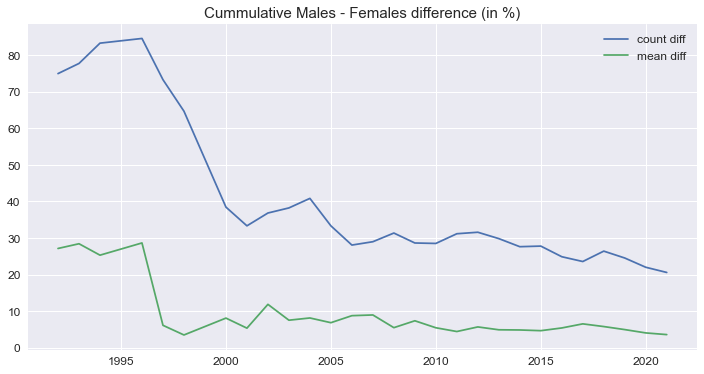

In [56]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(x=years_1990, y=cumm_count_dif)
sns.lineplot(x=years_1990, y=cumm_mean_dif)
ax.legend(["count diff", "mean diff"], fontsize=12)
plt.title("Cummulative Males - Females difference (in %)", fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

And the Training Set's frequency of topics per gender.

In [57]:
temporary = ["non" for idx in df.index]
for idx in df.index:
    if df["author_male"][idx] == 1:
        temporary[idx] = "male"
    if df["author_female"][idx] == 1:
        temporary[idx] = "female"
df["temporary"] = temporary

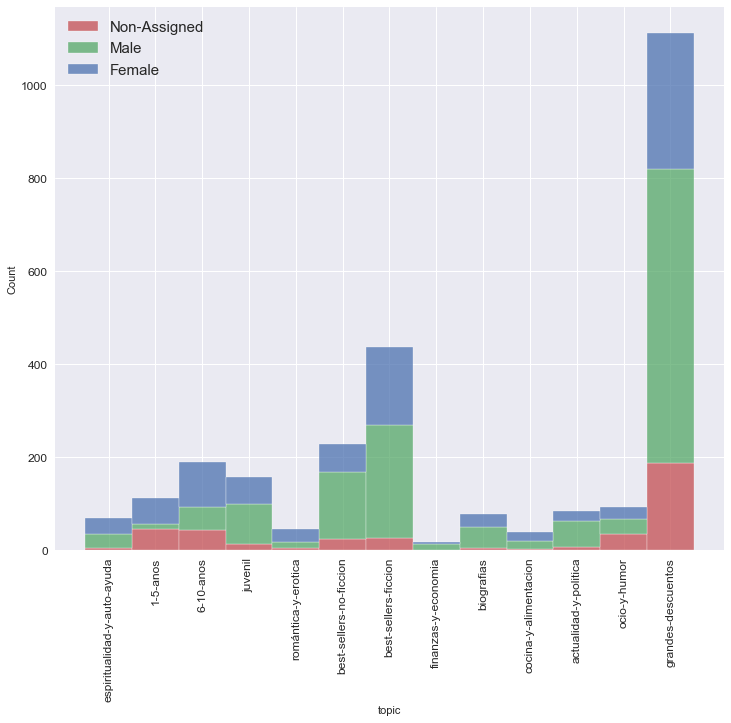

In [58]:
fig = plt.subplots(figsize=(12, 10))
sns.histplot(x="topic", hue="temporary", data=df.iloc[0:df.shape[0]-700], multiple="stack")
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.legend(["Non-Assigned", "Male", "Female"], fontsize=15)
plt.show()

In [59]:
df.drop(columns="temporary", inplace=True)

### Publisher

Some publishers has similar strings, that we may uniformize them

In [60]:
for idx in df.index:
    if not df["publisher"].isna()[idx]:
        df.at[idx, "publisher"] = df["publisher"][idx].replace("á", "a").replace("é", 
            "e").replace("í", "i").replace("ó", "o").replace("ú", "u")
        df.at[idx, "publisher"] = df["publisher"][idx].lower().replace(" ", "")

And obtain a total number of unique publishers of

In [61]:
print(df["publisher"].nunique())

365


In the Test Set the number of publishers that have a duplicate in the Training Set is

In [62]:
train_publishers = [df["publisher"][idx] for idx in range(df.shape[0]-700)]
test_publishers = [df["publisher"][idx] for idx in range(df.shape[0]-700, df.shape[0])]
num_check = 0
for pub in test_publishers:
    if pub in train_publishers:
        num_check += 1
print(num_check, "rows of a total of", test.shape[0], ".")

664 rows of a total of 700 .


**One possible way to encode a column with a large amount of unique objects is to consider the percentage of belonging to each target label** (in the Training Set).
First create the empty columns

In [63]:
for col in df["topic"].dropna().unique():
    df[col + "_Pub_Encode"] = 0.0

Then fill them with the percentages

In [64]:
unique_pub = df["publisher"].dropna().unique()
for pub in unique_pub:
    indexes = df[df["publisher"] == pub].index
    indexes_train = [i for i in indexes if i < df.shape[0]-700]
    if len(indexes_train) > 0:
        enc_vec = {top + "_Pub_Encode":0 for top in df["topic"].dropna().unique()}
        scale_factor = len(indexes_train)
        for col, val in enc_vec.items():
            update = 0
            for top in df.iloc[indexes_train]["topic"]:
                if top + "_Pub_Encode" == col:
                    update += 1
            update = round(update / scale_factor, 4)
            update_dic = {col: update}
            enc_vec.update(update_dic)
        for col, val in enc_vec.items():
            for idx in indexes:
                df.at[idx, col] = val

### Language

In language column we have the following unique values

In [65]:
print(df["language"].unique())

['Español' 'Castellano' nan 'Espanol' 'Inglés' 'Información no disponible'
 'Esspañol' 'Españo' 'Españolpáginas' 'Catalan' 'Castilian' 'Alemán']


for which the following indexes belong to Train and Test Set.

In [66]:
print("Indexes in Train Set:")
print("English:", [idx for idx in df[df["language"] == "Inglés"].index if idx < df.shape[0]-700])
print("Catalan:", [idx for idx in df[df["language"] == "Catalan"].index if idx < df.shape[0]-700])
print("German:", [idx for idx in df[df["language"] == "Alemán"].index if idx < df.shape[0]-700])
print("\n")
print("Indexes in Test Set:")
print("English:", [idx for idx in df[df["language"] == "Inglés"].index if idx >= df.shape[0]-700])
print("Catalan:", [idx for idx in df[df["language"] == "Catalan"].index if idx >= df.shape[0]-700])
print("German:", [idx for idx in df[df["language"] == "Alemán"].index if idx >= df.shape[0]-700])

Indexes in Train Set:
English: [104, 316, 1634, 1931, 2077, 2105, 2110, 2219, 2529, 2613]
Catalan: [2220]
German: []


Indexes in Test Set:
English: []
Catalan: []
German: [3279]


Just 1 book in the Test Set is in German language, and we have 0 German books in Traing Set. So we are ignoring the entire column

### Format

The unique formats are

In [67]:
print(df["format"].unique())

['Libro físico' nan 'Ebook' 'Libro fisico']


And similar to language column, there are only 2 books with "Ebook" format whose indexes belong to the Trainig Set.

In [68]:
print(df[df["format"] == "Ebook"].index)

Int64Index([721, 738], dtype='int64')


It makes sense to have a lower amount of Ebooks, as the data was scrapped from the "Fast-Shipping books" section. They should be mislabeled.
Again, we are omitting the entire column

## Preprocessed Data write

Finally we write two new datasets for the preprocessed data

In [71]:
train_1 = df.iloc[0:df.shape[0]-700].drop(columns=[
    "name", "author", "publisher", "year", "language", "pages", "format", "price", "url"
])
test_1 = df.iloc[df.shape[0]-700:df.shape[0]].drop(columns=[
    "name", "author", "publisher", "year", "language", "pages", "format", "price", "url", "topic"
]).reset_index(drop=True)
print(train_1.shape)
print(test_1.shape)

(2664, 21)
(700, 20)


CSV write:

In [72]:
train_1.to_csv("train_1.csv", index=False)
test_1.to_csv("test_1.csv", index=False)